# This code represents a trading strategy for 1 hour trading intervals
# The predictor is the high price of the AVAX cryptocurrency and the minimum threshold is 0.5

In [1]:
################# IMPORTS AND SETUP ##############################


from binance import Client
import pandas as pd
from supporting_functionsM2 import *
from API_KEYS2 import get_keys

# Setting up binance client
KEY, SECRET = get_keys()
client = Client(KEY, SECRET)

# Defining setup variables for creating dataset
# start = "1513724400" # 20.12.2017
start = "1483225200" # 01.01.2017
periods = 101 # approx 8 years
TICKER = "AVAXUSDT"
options = ["high", "low", "close", "volume"] # BASE OPTIONS
EPOCHS=5
THRESHOLD=0.5 # Threshold value for lableling, ie. BTCUSDT:close = 0.5 > 0.0 => label = 1, if BTCUSDT:close = -0.5 < 0.0 => 0
PREDICTOR=f"{TICKER}:high"
TIME = f"{TICKER}:time"

In [2]:
################# DOWNLOADING RAW DATA ##########################################

periods = periods
LIMIT = 720 # 720h = 30 days
start1 = start
end1 = next_30_days_unix_timestamp(start1)

############################################ DOWNLOADING DATA ###################################################################### 
data = pd.DataFrame(columns=["time", "open", "high", "low", "close", "volume"])

# downloading the first set of candlestick lines
klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

# Converting data from list to pandas dataframe
new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])
data = pd.concat([data, new_data], ignore_index=True)

for i in range(periods - 1):
    # Moving the start and end interval to next day
    start1 = next_30_days_unix_timestamp(start1)
    end1 = next_30_days_unix_timestamp(start1) 

    # downloading candlestick lines
    klines = client.get_historical_klines(TICKER, client.KLINE_INTERVAL_1HOUR, limit=LIMIT, start_str=unix_to_datetime_string(start1, in_milliseconds=False), end_str=unix_to_datetime_string(end1, in_milliseconds=False))
    # print(klines)

    # Converting data from list to pandas dataframe
    new_data = pd.DataFrame(data=[row[0:6] for row in klines], columns=["time", "open", "high", "low", "close", "volume"])

    # concatinating the new data with the existing data
    data = pd.concat([data, new_data], ignore_index=True)

# converting all time values from unix to readable string, not important, just for visual purposes and fact checking
data["time"] = data["time"].apply(unix_to_datetime_string) #converting time from 

raw_data = data
display(raw_data)


,time,open,high,low,close,volume
0,2020-09-22 06:00:00,0.85000000,6.00000000,0.85000000,4.88110000,3198372.67000000
1,2020-09-22 07:00:00,4.88000000,5.35000000,4.24500000,4.90960000,3171013.60000000
2,2020-09-22 08:00:00,4.90960000,6.92890000,4.82000000,6.82190000,3883981.43000000
3,2020-09-22 09:00:00,6.82990000,7.00000000,5.55000000,6.21080000,3681832.89000000
4,2020-09-22 10:00:00,6.21090000,6.30000000,4.97500000,5.49010000,2729116.18000000
...,...,...,...,...,...,...
40056,2025-04-18 18:00:00,19.10000000,19.15000000,19.07000000,19.12000000,18795.96000000
40057,2025-04-18 19:00:00,19.12000000,19.17000000,19.08000000,19.16000000,38488.00000000
40058,2025-04-18 20:00:00,19.16000000,19.19000000,19.09000000,19.15000000,36401.15000000
40059,2025-04-18 21:00:00,19.16000000,19.22000000,19.10000000,19.20000000,21497.16000000


In [3]:
raw_close = raw_data['close'].to_list()
print(f"PERCENT RETURN EVALUATION SET: {round(percent_difference(float(raw_close[-10000]), float(raw_close[-1])), 3)}%")

PERCENT RETURN EVALUATION SET: -50.908%


In [4]:
########################################## PREPROCESSING DATA ####################################################################

# New dataobject for storing processed data
# processed_data = {f"{TICKER}:time": [], f"{TICKER}:open": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}
processed_data = {f"{TICKER}:time": [], f"{TICKER}:high": [], f"{TICKER}:low": [], f"{TICKER}:close": [], f"{TICKER}:volume": []}

for i, o in enumerate(raw_data["open"]): #o == open, the open price value of the candle stick
    if i == 0: #Skipping the first hour to calculate the percent diff using this hour
        continue

    if o == 0:
        continue

    processed_data[f"{TICKER}:time"].append(raw_data["time"][i]) #time is the same
    # processed_data[f"{TICKER}:open"].append(percent_difference(float(data["open"][i-1]), float(o))) # percent difference between the opening price of the prior candlestick vs. open of current candle
    processed_data[f"{TICKER}:high"].append(percent_difference(float(o), float(raw_data["high"][i]))) # percent diff between open and high
    processed_data[f"{TICKER}:low"].append(percent_difference(float(o), float(raw_data["low"][i]))) # percent diff between open and low
    processed_data[f"{TICKER}:close"].append(percent_difference(float(o), float(raw_data["close"][i]))) # percent diff between open and close
    processed_data[f"{TICKER}:volume"].append(percent_difference(float(raw_data["volume"][i-1]), float(raw_data["volume"][i]))) # percent difference between the colume of the prior candlestick vs. open of current candle


# processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:open", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
processed_data = pd.DataFrame(data=processed_data, columns=[f"{TICKER}:time", f"{TICKER}:high", f"{TICKER}:low", f"{TICKER}:close", f"{TICKER}:volume"])
display(processed_data)

,AVAXUSDT:time,AVAXUSDT:high,AVAXUSDT:low,AVAXUSDT:close,AVAXUSDT:volume
0,2020-09-22 07:00:00,9.631148,-13.012295,0.606557,-0.855406
1,2020-09-22 08:00:00,41.129624,-1.824996,38.950220,22.483910
2,2020-09-22 09:00:00,2.490520,-18.739659,-9.064554,-5.204673
3,2020-09-22 10:00:00,1.434575,-19.898887,-11.605403,-25.876153
4,2020-09-22 11:00:00,12.410210,-4.628988,5.157703,-29.960694
...,...,...,...,...,...
40055,2025-04-18 18:00:00,0.261780,-0.157068,0.104712,-38.930515
40056,2025-04-18 19:00:00,0.261506,-0.209205,0.209205,104.767407
40057,2025-04-18 20:00:00,0.156576,-0.365344,-0.052192,-5.422080
40058,2025-04-18 21:00:00,0.313152,-0.313152,0.208768,-40.943734


In [5]:
############################# STATISTICAL ANALYSIS OF PROCESSED DATA #######################################
import statistics as st

high_data_processed = processed_data[f"{TICKER}:high"].to_list()
high_data_processed = high_data_processed[:-10000]
print(f"TOTAL DATAPOINTS: {len(high_data_processed)}")
print(f"MEAN HIGH: {st.mean(high_data_processed)}")
print(f"MEDIAN HIGH: {st.median(high_data_processed)}")

print(f"MAX HIGH IN DATASET: {max(high_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.5 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.6 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.7 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.8 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.9 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 1 for x in high_data_processed) / len(high_data_processed), 2)}%")
print("----------------------------------------------------------------------")

print("EVALUATION DATASET STATISTICS")
high_data_processed = processed_data[f"{TICKER}:high"].to_list()
high_data_processed = high_data_processed[-10000:]
print(f"TOTAL DATAPOINTS: {len(high_data_processed)}")
print(f"MEAN HIGH: {st.mean(high_data_processed)}")
print(f"MEDIAN HIGH: {st.median(high_data_processed)}")

print(f"MAX HIGH IN DATASET: {max(high_data_processed)}")
print(f"OCCURRENCES OVER 0.5: {sum(x > 0.5 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.5 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.6: {sum(x > 0.6 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.6 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.7: {sum(x > 0.7 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.7 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.8: {sum(x > 0.8 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.8 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 0.9: {sum(x > 0.9 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 0.9 for x in high_data_processed) / len(high_data_processed), 2)}%")
print(f"OCCURRENCES OVER 1: {sum(x > 1 for x in high_data_processed)} - PERCENT OF DATASET: {round(sum(x > 1 for x in high_data_processed) / len(high_data_processed), 2)}%")
print("----------------------------------------------------------------------")

TOTAL DATAPOINTS: 30060
MEAN HIGH: 0.9558046574158933
MEDIAN HIGH: 0.5796607321978342
MAX HIGH IN DATASET: 41.12962359459018
OCCURRENCES OVER 0.5: 16535 - PERCENT OF DATASET: 0.55%
OCCURRENCES OVER 0.6: 14689 - PERCENT OF DATASET: 0.49%
OCCURRENCES OVER 0.7: 13012 - PERCENT OF DATASET: 0.43%
OCCURRENCES OVER 0.8: 11613 - PERCENT OF DATASET: 0.39%
OCCURRENCES OVER 0.9: 10342 - PERCENT OF DATASET: 0.34%
OCCURRENCES OVER 1: 9263 - PERCENT OF DATASET: 0.31%
----------------------------------------------------------------------
EVALUATION DATASET STATISTICS
TOTAL DATAPOINTS: 10000
MEAN HIGH: 0.7489562291980103
MEDIAN HIGH: 0.5176289030761085
MAX HIGH IN DATASET: 9.604863221884502
OCCURRENCES OVER 0.5: 5128 - PERCENT OF DATASET: 0.51%
OCCURRENCES OVER 0.6: 4457 - PERCENT OF DATASET: 0.45%
OCCURRENCES OVER 0.7: 3809 - PERCENT OF DATASET: 0.38%
OCCURRENCES OVER 0.8: 3276 - PERCENT OF DATASET: 0.33%
OCCURRENCES OVER 0.9: 2847 - PERCENT OF DATASET: 0.28%
OCCURRENCES OVER 1: 2452 - PERCENT OF DAT

In [6]:
########################### LABELING THE DATA ##################################


# column_labels = ["BTCUSDT:time"] # name of the columns for the return dataframe
column_labels = ["time"] # name of the columns for the return dataframe

# filling up the list with labels for the columns
for roundd in range(EPOCHS):
    for option in options:
        column_labels.append(f"{TICKER}:{option}{roundd}")

column_labels.append("Label")


# filling up list of data, row by row in the dataset
labelled_data_rows = [] # this list stores all the rows filled with all the data
for i in range(len(processed_data[TIME]) - EPOCHS): #looping from the third element to the third last element, with stepsize 1, if epoch=3
    data_row = []

    data_row.append(processed_data[TIME][i + EPOCHS - 1])

    for t in range(EPOCHS):
        for option in options:
            data_row.append(processed_data[f"{TICKER}:{option}"][i + t])

    if processed_data[PREDICTOR][i + EPOCHS] > THRESHOLD: # here we use the threshold
        data_row.append(1)
    else:
        data_row.append(0)

    labelled_data_rows.append(data_row)


labelled_data_frame = pd.DataFrame(labelled_data_rows, columns=column_labels)
display(labelled_data_frame)

,time,AVAXUSDT:high0,AVAXUSDT:low0,AVAXUSDT:close0,AVAXUSDT:volume0,AVAXUSDT:high1,AVAXUSDT:low1,AVAXUSDT:close1,AVAXUSDT:volume1,AVAXUSDT:high2,...,AVAXUSDT:volume2,AVAXUSDT:high3,AVAXUSDT:low3,AVAXUSDT:close3,AVAXUSDT:volume3,AVAXUSDT:high4,AVAXUSDT:low4,AVAXUSDT:close4,AVAXUSDT:volume4,Label
0,2020-09-22 11:00:00,9.631148,-13.012295,0.606557,-0.855406,41.129624,-1.824996,38.950220,22.483910,2.490520,...,-5.204673,1.434575,-19.898887,-11.605403,-25.876153,12.410210,-4.628988,5.157703,-29.960694,1
1,2020-09-22 12:00:00,41.129624,-1.824996,38.950220,22.483910,2.490520,-18.739659,-9.064554,-5.204673,1.434575,...,-25.876153,12.410210,-4.628988,5.157703,-29.960694,6.624595,-5.636367,1.536088,-26.807353,1
2,2020-09-22 13:00:00,2.490520,-18.739659,-9.064554,-5.204673,1.434575,-19.898887,-11.605403,-25.876153,12.410210,...,-29.960694,6.624595,-5.636367,1.536088,-26.807353,2.108768,-8.882438,-5.896013,-21.374516,1
3,2020-09-22 14:00:00,1.434575,-19.898887,-11.605403,-25.876153,12.410210,-4.628988,5.157703,-29.960694,6.624595,...,-26.807353,2.108768,-8.882438,-5.896013,-21.374516,1.625425,-8.365302,-6.238068,8.670055,0
4,2020-09-22 15:00:00,12.410210,-4.628988,5.157703,-29.960694,6.624595,-5.636367,1.536088,-26.807353,2.108768,...,-21.374516,1.625425,-8.365302,-6.238068,8.670055,0.089282,-16.327006,-9.361050,93.927123,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40050,2025-04-18 17:00:00,0.052274,-0.522739,-0.052274,-3.084353,0.261643,-0.837258,-0.575615,98.772222,0.105319,...,-22.655548,0.317460,-0.105820,0.264550,-35.335423,0.791557,-0.211082,0.791557,22.501413,0
40051,2025-04-18 18:00:00,0.261643,-0.837258,-0.575615,98.772222,0.105319,-0.737230,-0.421274,-22.655548,0.317460,...,-35.335423,0.791557,-0.211082,0.791557,22.501413,0.261780,-0.157068,0.104712,-38.930515,0
40052,2025-04-18 19:00:00,0.105319,-0.737230,-0.421274,-22.655548,0.317460,-0.105820,0.264550,-35.335423,0.791557,...,22.501413,0.261780,-0.157068,0.104712,-38.930515,0.261506,-0.209205,0.209205,104.767407,0
40053,2025-04-18 20:00:00,0.317460,-0.105820,0.264550,-35.335423,0.791557,-0.211082,0.791557,22.501413,0.261780,...,-38.930515,0.261506,-0.209205,0.209205,104.767407,0.156576,-0.365344,-0.052192,-5.422080,0


# Model Training

This code block divides the dataset into a training dataset and trains a new model using the **AutoGluon Tabular** predictor.

In [7]:
################################ TRAINING NEW MODEL #######################################
from autogluon.tabular import TabularDataset, TabularPredictor

# defining training size and colums to use for training within the labelled dataset
VALIDATION_SIZE = 10000
columns_to_use = [f"{TICKER}:high0", f"{TICKER}:low0", f"{TICKER}:close0", f"{TICKER}:volume0", f"{TICKER}:high1", f"{TICKER}:low1", f"{TICKER}:close1", f"{TICKER}:volume1", f"{TICKER}:high2", f"{TICKER}:low2", f"{TICKER}:close2", f"{TICKER}:volume2", f"{TICKER}:high3", f"{TICKER}:low3", f"{TICKER}:close3", f"{TICKER}:volume3", f"{TICKER}:high4", f"{TICKER}:low4", f"{TICKER}:close4", f"{TICKER}:volume4", "Label"]
LABEL = "Label"

# defining training data
training_dataframe = labelled_data_frame.iloc[:-VALIDATION_SIZE].copy()
train_data_frame2 = training_dataframe[columns_to_use]
train_tabular_dataset = TabularDataset(train_data_frame2)

# # Training model -> TabularPredictor
# predictor = TabularPredictor(label=label, eval_metric="balanced_accuracy", positive_class=1).fit(train_tabular_dataset, num_bag_folds=5, num_bag_sets=5, num_stack_levels=3)
# predictor = TabularPredictor(label=label, eval_metric="accuracy").fit(train_tabular_dataset, presets="high_quality")
predictor = TabularPredictor(label=LABEL).fit(train_tabular_dataset)



c:\Users\47981\Desktop\MasterThesis\Repo\MasterThesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels\ag-20250603_091925"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.27 GB / 15.92 GB (26.8%)
Disk Space Avail:   138.01 GB / 475.69 GB (29.0%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Defau

# Model Evaluation

This code block divides the dataset into a validation dataset and evaluates the model using the **AutoGluons** inbuilt evaluation library. In addition the model is backtested using the validation set to measure its performance and calulate its "expected return" over the period.

In [8]:
#################### MODEL EVALUATION ################################

# Defining the testing set using the training size and columns to use
testing_dataframe = labelled_data_frame.tail(VALIDATION_SIZE).copy()
#display(testing_dataframe)
test_data_frame2 = testing_dataframe[columns_to_use]
test_tabular_dataset = TabularDataset(test_data_frame2)

######## Making predictions
y_pred = predictor.predict(test_tabular_dataset.drop(columns=[LABEL]))
display(y_pred)


#### Evaluation
eval_report = predictor.evaluate(test_tabular_dataset, detailed_report=True)
display(eval_report)

feature_importance = predictor.feature_importance(test_tabular_dataset)
display(feature_importance)


30055    0
30056    1
30057    0
30058    0
30059    0
        ..
40050    0
40051    0
40052    0
40053    0
40054    0
Name: Label, Length: 10000, dtype: int64

{'accuracy': 0.6031,
 'balanced_accuracy': 0.601771496968253,
 'mcc': 0.2046959155523864,
 'roc_auc': 0.6471431717490373,
 'f1': 0.6281270495643212,
 'precision': 0.6045085662759243,
 'recall': 0.6536661466458659,
 'confusion_matrix':       0     1
 0  2679  2193
 1  1776  3352,
 'classification_report': {'0': {'precision': 0.6013468013468013,
   'recall': 0.5498768472906403,
   'f1-score': 0.5744612415567707,
   'support': 4872.0},
  '1': {'precision': 0.6045085662759243,
   'recall': 0.6536661466458659,
   'f1-score': 0.6281270495643212,
   'support': 5128.0},
  'accuracy': 0.6031,
  'macro avg': {'precision': 0.6029276838113629,
   'recall': 0.601771496968253,
   'f1-score': 0.601294145560546,
   'support': 10000.0},
  'weighted avg': {'precision': 0.6029681544024555,
   'recall': 0.6031,
   'f1-score': 0.6019810679030426,
   'support': 10000.0}}}

Computing feature importance via permutation shuffling for 20 features using 5000 rows with 5 shuffle sets...
	28.39s	= Expected runtime (5.68s per shuffle set)
	6.19s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
AVAXUSDT:high4,0.02924,0.003339,0.000020,5,0.036115,0.022365
AVAXUSDT:low4,0.01912,0.004717,0.000411,5,0.028833,0.009407
AVAXUSDT:high3,0.00700,0.001844,0.000528,5,0.010797,0.003203
AVAXUSDT:high2,0.00416,0.003363,0.025263,5,0.011084,-0.002764
AVAXUSDT:close4,0.00408,0.004985,0.070609,5,0.014345,-0.006185
AVAXUSDT:high0,0.00392,0.003515,0.033597,5,0.011156,-0.003316
AVAXUSDT:low0,0.00352,0.003825,0.054370,5,0.011396,-0.004356
AVAXUSDT:volume4,0.00292,0.003551,0.069917,5,0.010232,-0.004392
AVAXUSDT:volume2,0.00116,0.001090,0.038004,5,0.003404,-0.001084
AVAXUSDT:low3,0.00112,0.002077,0.147128,5,0.005396,-0.003156


In [ ]:
import re
import pandas as pd

METRIC_RE = re.compile(r":([a-zA-Z]+?)(\d+)$")   # capture metric & hour suffix


def analyze_feature_importance(feature_names, importances):
    """
    Print a short report on a model’s feature-importance vector.

    Parameters
    ----------
    feature_names : list[str]
        All feature names, e.g. ["SOLUSDT:high4", "SOLUSDT:low2", ...]
    importances : list[float]
        Matching importance values, same length/order as `feature_names`
    """
    if len(feature_names) != len(importances):
        raise ValueError("feature_names and importances must be the same length!")

    # ── Build a DataFrame ────────────────────────────────────────────────────
    df = pd.DataFrame(
        {"feature": feature_names, "importance": importances}
    ).assign(
        metric=lambda d: d["feature"].str.extract(METRIC_RE)[0].str.lower(),
        hour=lambda d: pd.to_numeric(
            d["feature"].str.extract(METRIC_RE)[1], errors="coerce"
        ),
    )

    # Drop rows we could not parse
    df = df.dropna(subset=["metric", "hour"]).copy()
    df["hour"] = df["hour"].astype(int)

    # ── 1. % of positive importances ────────────────────────────────────────
    pct_pos = (df["importance"] > 0).mean() * 100

    # ── 2. Rank by hour (sum of importances per lag) ────────────────────────
    hour_scores = df.groupby("hour")["importance"].sum().sort_values(ascending=False)
    hour_ranking = hour_scores.index.tolist()

    # ── 3. Rank by metric (sum of importances per metric) ───────────────────
    metric_scores = (
        df.groupby("metric")["importance"].sum().sort_values(ascending=False)
    )
    metric_ranking = metric_scores.index.tolist()

    # ── Report ──────────────────────────────────────────────────────────────
    print(f"{pct_pos:.1f}% of the {len(df)} features have **positive** importance.\n")

    print("Ranking by HOUR (most → least important):")
    for i, h in enumerate(hour_ranking, 1):
        print(f"  {i}. h{h:<1}   sum importance = {hour_scores[h]:.6f}")

    print("\nRanking by METRIC (most → least important):")
    for i, m in enumerate(metric_ranking, 1):
        print(f"  {i}. {m:<6} sum importance = {metric_scores[m]:.6f}")

    top_features = (
        df.loc[df["importance"].abs().sort_values(ascending=False).index]
        .head(5)[["feature", "importance"]]
    )
    print("\nTop 5 individual features:")
    for feat, imp in top_features.itertuples(index=False):
        print(f"  {feat:<25} {imp:.6f}")




analyze_feature_importance(feature_importance.index.to_list(), feature_importance['importance'].to_list())

In [9]:
# ANALYSIS OF PREDICTIONS AND PROBABILITIES

import statistics as st

# making and processing probabilities from evaluation dataset
y_prob = predictor.predict_proba(test_tabular_dataset.drop(columns=[LABEL]))

validation_probabilities = pd.DataFrame(y_prob).reset_index(drop=True) # probability for each prediction
validation_predictions = pd.DataFrame(y_pred).reset_index(drop=True)
validation_dataset = pd.DataFrame(test_data_frame2).reset_index(drop=True)
#display(validation_probabilities)
#display(validation_predictions)
#display(validation_dataset)

print(f"MEAN PROB 1 CLASSIFICATION: {st.mean(validation_probabilities[1].to_list())}")
print(f"MAX PROB 1 CLASSIFICATION: {max(validation_probabilities[1].to_list())}")
print(f"MIN PROB 1 CLASSIFICATION: {min(validation_probabilities[1].to_list())}")

count_above_07 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.7)
print("COUNT OF NUMBERS > 0.7:", count_above_07)

count_above_08 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.8)
print("COUNT OF NUMBERS > 0.8:", count_above_08)

count_above_09 = sum(1 for num in validation_probabilities[1].to_list() if num > 0.9)
print("COUNT OF NUMBERS > 0.9:", count_above_09)








MEAN PROB 1 CLASSIFICATION: 0.5196500727638602
MAX PROB 1 CLASSIFICATION: 0.9646732211112976
MIN PROB 1 CLASSIFICATION: 0.09125111252069473
COUNT OF NUMBERS > 0.7: 1240
COUNT OF NUMBERS > 0.8: 344
COUNT OF NUMBERS > 0.9: 38


NUMBER OF TRADES: 1240
ACCURACY: 72.58%
RETURN: -21.18%
SHARP RATIO: -0.38801588359308276
SHARP RATIO ONLY HOLDING ASSET: -0.21084627661099462
MEAN RETURN BAD TRADES: -1.3692558823529413
----------------------------------
-1.474
-0.709
-2.713
-0.092
-2.795
0.258
-1.363
-1.35
-1.933
-5.064
-0.915
-1.038
-0.902
-1.003
-1.9
-1.637
-2.669
-0.57
-2.167
-1.432
-4.505
-1.104
-6.716
-2.222
-2.237
0.247
-0.396
-2.537
-1.96
-1.844
-3.265
-3.32
-0.186
-2.439
-1.46
-2.387
-1.413
-3.164
-1.23
-2.727
-3.382
-6.047
-1.962
-2.192
-3.073
-1.603
-4.802
-2.358
-0.282
-2.164
-0.859
-1.523
-0.4
-3.722
-1.48
-0.148
0.161
-1.398
-0.111
-0.75
-0.453
-0.908
-0.612
-0.488
-1.186
-0.164
0.422
-0.065
-4.365
-8.615
-1.653
-1.422
-0.028
-0.944
-3.057
-1.153
0.029
-0.826
-1.013
-0.673
-1.889
-0.893
-0.152
-1.889
-0.142
-0.851
-0.799
-1.358
-0.376
-1.161
-5.16
-0.94
-1.378
0.035
-0.691
-0.318
-0.898
-2.328
0.078
-1.187
-6.773
-0.443
0.0
-0.482
-1.244
-0.035
-0.036
-1.811
-0.381
-0.205
-0.594
-0.685
-1.615
-1.403
0.04

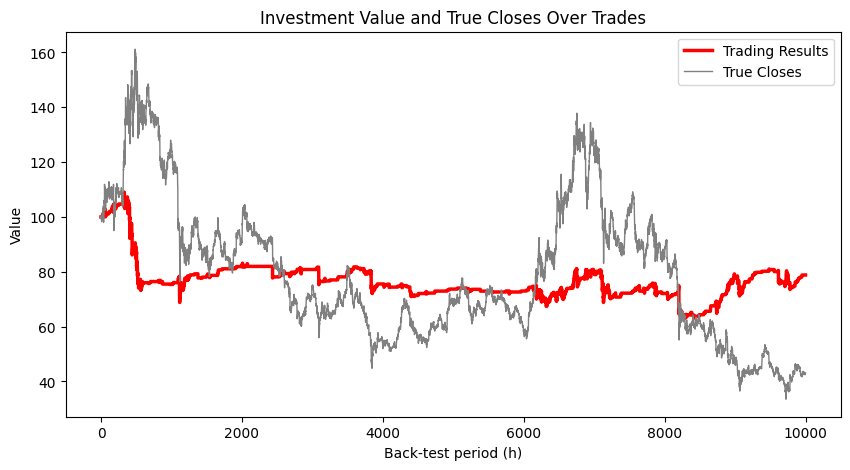

In [11]:
import matplotlib.pyplot as plt

# --- Constants ---
MINIMUM_PROBABILITY = 0.7
LEVERAGE = 1
FEE = 0.0
GAIN = 0.5 - FEE  # Interpreted as a percentage (e.g., 0.5% if multiplied by /100)


# --- Tracking variables ---
correct_trades = 0
total_trades = 0
bad_trades = []
all_trades = []

initial_investment = 100
current_investment = initial_investment
investment_history = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        total_trades += 1
        
        # Check if the prediction was correct
        if validation_predictions["Label"][idx] == validation_dataset["Label"][idx]:
            correct_trades += 1
            
            # Record the "gain" in your trade list
            all_trades.append(GAIN * LEVERAGE)
            
            # Update current_investment by a factor of (1 + gain%)
            current_investment *= 1 + (GAIN / 100 * LEVERAGE)
        
        else:
            # Grab the next close price; watch out for index out-of-range in real code
            true_close = (validation_dataset[f"{TICKER}:close4"][idx + 1]) - FEE
            
            # Record the trade details
            bad_trades.append(round(true_close * LEVERAGE, 3))
            all_trades.append(true_close * LEVERAGE)

            # Update current_investment by (1 + some factor of true_close?)
            current_investment *= 1 + (true_close / 100 * LEVERAGE)
    
    else:
        all_trades.append(0)

    # In all cases, record the current investment amount
    investment_history.append(current_investment)

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0
total_return = current_investment - initial_investment

# --- Print results ---
#print(f"CORRECT: {correct_trades}")
#print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"ACCURACY: {round(win_rate, 2)}%")
print(f"RETURN: {round(total_return, 2)}%")
#print(f"INVESTMENT VALUE: {round(current_investment, 2)}")
print(f"SHARP RATIO: {calculate_sharpe_ratio(all_trades)}")
sharpe_ratio9999 = calculate_sharpe_ratio(validation_dataset[f"{TICKER}:close4"].to_list())
print(f"SHARP RATIO ONLY HOLDING ASSET: {sharpe_ratio9999}")
print(f"MEAN RETURN BAD TRADES: {st.mean(bad_trades)}")
print("-" * 34)

# Print information about bad trades
for trade in bad_trades:
    print(trade)

# --- Plot the investment history ---
true_closes_list = validation_dataset[f"{TICKER}:close4"].to_list()
true_close_base = 100
true_close_base_list = []

for close in true_closes_list:
    true_close_base *= 1 + (close / 100)
    true_close_base_list.append(true_close_base)


plt.figure(figsize=(10,5))
plt.plot(investment_history, label="Trading Results", color='red', linewidth=2.5)
plt.plot(true_close_base_list, label="True Closes", color='gray', linewidth=1)
plt.xlabel("Back-test period (h)")
plt.ylabel("Value")
plt.title("Investment Value and True Closes Over Trades")
plt.legend()
plt.show()

In [ ]:
############### ANALYSIS OF TRADING USING CLOSING PRICE ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.8
TRADING_FEE = 0.25

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []

# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE
        
        if true_close >= 0:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)
            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")

investtt = 100
investment_history2 = []
for trade in all_trades:
    investtt *= 1 + (trade / 100)
    investment_history2.append(investtt)
    # print(trade)

print(f"RETURN: {round(investtt - 100, 3)} %")

# --- Plot the investment history ---
plt.plot(investment_history2)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()

In [ ]:
############### ANALYSIS OF TRADING USING CLOSING PRICE ################################

# --- Constants ---
MINIMUM_PROBABILITY = 0.8
TRADING_FEE = 0.25
LEVERAGE = 1

# --- Tracking variables ---
correct_trades = 0
total_trades = 0
wrong_trades = 0

all_trades = []
good_trades = []
bad_trades = []
investment_value = 100
investment_history = []


# Go through probabilities alongside their index
for idx, prob in enumerate(validation_probabilities[1].to_list()):
    
    # Check if the predicted probability meets the threshold
    if prob >= MINIMUM_PROBABILITY:
        true_close = (validation_dataset[f"{TICKER}:close4"][idx + 1] - TRADING_FEE) * LEVERAGE
        
        if true_close >= 0:
            correct_trades += 1
            good_trades.append(true_close)
        else:
            bad_trades.append(true_close)



        total_trades += 1
        all_trades.append(true_close)

        investment_value *= 1 + (true_close / 100)
        investment_history.append(investment_value)
    
    else:
        investment_history.append(investment_value)

            

# --- After the loop, calculate stats ---
wrong_trades = total_trades - correct_trades
win_rate = (correct_trades / total_trades * 100) if total_trades else 0

# --- Print results ---
print(f"CORRECT: {correct_trades}")
print(f"WRONG: {wrong_trades}")
print(f"NUMBER OF TRADES: {total_trades}")
print(f"WIN RATE: {round(win_rate, 2)}%")
print("-" * 34)

print(f"MEAN GOOD TRADES: {st.mean(good_trades)}")
print(f"MEAN BAD TRADES: {st.mean(bad_trades)}")
print(f"INVESTMENT VALUE {investment_value}")

# investtt = 100
# investment_history2 = []
# for trade in all_trades:
#     investtt *= 1 + (trade / 100)
#     investment_history2.append(investtt)
#     # print(trade)

# print(f"RETURN: {round(investtt - 100, 3)} %")


from matplotlib import pyplot as plt
# --- Plot the investment history ---


plt.plot(investment_history)
plt.xlabel("Trade Index")
plt.ylabel("Investment Value")
plt.title("Investment Value Over Trades")
plt.show()